In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.io
from sklearn.metrics import confusion_matrix
import anndata as ad
import re
from datetime import datetime
import os

from scepia.sc import (
    infer_motifs, 
    plot
)  

%matplotlib inline

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.set_figure_params(dpi=150)

work_dir = "path_to_files/Py_analysis/" 
dataset_path = "path_to_files/R_analysis/20210712_PythonTransfer_SCEPIA_PC30_res1.6/"
result_descript = "_SCEPIA_H3K27Ac_Human_threeClusters/"

-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.1
-----
Bio                 1.79
HTSeq               0.13.5
PIL                 8.3.1
adjustText          NA
anndata             0.7.6
appdirs             1.4.4
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
boltons             NA
brotli              NA
bucketcache         0.12.1
certifi             2021.05.30
cffi                1.14.6
chardet             4.0.0
colorama            0.4.4
concurrent          NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.3.0
decorator           4.4.2
defusedxml          0.7.1
diskcache           5.2.1
encodings           NA
fbpca               NA
fluff               NA
genericpath         NA
genomepy            0.9.3
geosketch           1.2
gimmemotifs         0.16.1
h5py                3.3.0
idna                2.10
igraph              0.9.6
ipykernel           6.0.1
ipython_genutils    0.2.0
ipywidgets          7.6.3

In [2]:
today = datetime.now()
work_dir = work_dir + "/" + today.strftime('%Y%m%d') + result_descript + "/"
os.mkdir(work_dir)

#### Data locations & Other parameters

In [3]:
## Data locations ##
raw_spliced_path = dataset_path + "seurat_sf_counts.mtx"
raw_unspliced_path = dataset_path + "seurat_uf_counts.mtx"
scaled_spliced_path = dataset_path + "seurat_sf_scaled_counts.csv"
scaled_unspliced_path = dataset_path + "seurat_uf_scaled_counts.csv"

## Loading Metadata from another location for merging of clusters
metadata_path = "path_to_files/R_analysis/20210913_ClusterMerging/seurat_metadata.csv"
featuredata_path = dataset_path + "seurat_HVG.csv"
umap_path = dataset_path + "seurat_umap_embedding.csv"

## Parameters to set ##
pc_set = 30

#### Loading data

In [4]:
raw_spliced = scipy.io.mmread(raw_spliced_path)
raw_unspliced = scipy.io.mmread(raw_unspliced_path)
scaled_spliced = np.asmatrix(pd.read_csv(scaled_spliced_path, index_col = 0))
scaled_unspliced = np.asmatrix(pd.read_csv(scaled_unspliced_path, index_col = 0))
metadata = pd.read_csv(metadata_path, index_col = 0)
featuredata = pd.read_csv(featuredata_path, index_col = 0)
umap_embedding = np.asmatrix(pd.read_csv(umap_path, index_col = 0))

In [5]:
## Building the adata object, matrices from Seurat need Transposing before adding.
adata = ad.AnnData(X = scaled_spliced.T,
                   obs = metadata,
                   var = featuredata
                  )
adata.layers["spliced"] = scaled_spliced.T
adata.layers["unspliced"] = scaled_unspliced.T
adata.obsm["X_umap"] = umap_embedding

In [6]:
adata.var['highly_variable'] = adata.var['vst.variable']
adata.var['dispersions_norm'] = adata.var['vst.variance.standardized']
adata.obs['louvain'] = adata.obs['three_clusters']
adata

AnnData object with n_obs × n_vars = 6636 × 21099
    obs: 'orig.ident', 'nCount_sf', 'nFeature_sf', 'Experiment', 'Replicate', 'Index', 'Flowcell', 'Well', 'combined_id', 'Adapter', 'Plate', 'Library.day', 'Bio.Size', 'Concentration', 'Timepoint', 'SubmissionName', 'Libnumber', 'is_cell_control', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_features_by_counts_endogenous', 'log10_total_features_by_counts_endogenous', 'total_counts_endogenous', 'log10_total_counts_endogenous', 'pct_counts_endogenous', 'pct_counts_in_top_50_features_endogenous', 'pct_counts_in_top_100_features_endogenous', 'pct_counts_in_top_200_features_endogenous', 'pct_counts_in_top_500_features_endogenous', 'total_features_by_counts_feature_control', 'log10_total_features_by_counts_feature_control', 'total_counts_feature_co

In [7]:
scaled_spliced[1:10,1:10]

matrix([[-2.58352989e-01, -3.43765477e-01, -3.19193578e-01,
         -3.70052028e-01, -3.55753097e-01, -4.00458918e-01,
         -3.92731167e-01, -1.78643797e-01,  2.97539485e+00],
        [-2.99816393e-01, -3.30335964e-01, -3.23208388e-01,
         -3.40782277e-01, -3.39242203e-01, -3.50275507e-01,
         -3.09318017e-01, -2.66937675e-01, -3.41038600e-01],
        [-6.69455768e-02, -5.52921098e-02,  1.00000000e+01,
         -5.26208093e-02, -5.76719638e-02, -4.72806557e-02,
         -1.51575397e-02, -7.40015976e-02, -5.25626938e-02],
        [-8.29870091e-02, -1.26720833e-01, -1.11087109e-01,
         -1.38234290e-01, -1.24320281e-01, -1.56337248e-01,
         -2.22930663e-01, -5.02950078e-02, -1.38497306e-01],
        [-2.73733370e-01, -4.46668323e-01, -3.92841216e-01,
         -4.97291727e-01, -4.59536011e-01, -5.62240531e-01,
         -6.40817394e-01, -1.23192630e-01, -4.98485552e-01],
        [-4.86567411e-01,  1.21800396e+00,  2.47071453e+00,
         -8.36891464e-01, -7.743899

In [8]:
adata.obs = adata.obs.astype(str)
#adata.var_names_make_unique()

In [9]:
adata.raw = adata

#### Select the HVG & run neighbors
In `adata.var['vst.variable']` the HVG are stored from Seurat Analysis

In [10]:
# Filter adata on HVG
adata = adata[:, adata.var['highly_variable']]

In [11]:
# SCEPIA: louvain clustering, n_neighbors in Seurat = 20
sc.pp.neighbors(adata, n_neighbors = 20, n_pcs= pc_set)
#sc.tl.louvain(adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


... storing 'orig.ident' as categorical
... storing 'nCount_sf' as categorical
... storing 'nFeature_sf' as categorical
... storing 'Experiment' as categorical
... storing 'Replicate' as categorical
... storing 'Index' as categorical
... storing 'Flowcell' as categorical
... storing 'Well' as categorical
... storing 'combined_id' as categorical
... storing 'Adapter' as categorical
... storing 'Plate' as categorical
... storing 'Library.day' as categorical
... storing 'Bio.Size' as categorical
... storing 'Concentration' as categorical
... storing 'Timepoint' as categorical
... storing 'SubmissionName' as categorical
... storing 'Libnumber' as categorical
... storing 'is_cell_control' as categorical
... storing 'total_features_by_counts' as categorical
... storing 'log10_total_features_by_counts' as categorical
... storing 'total_counts' as categorical
... storing 'log10_total_counts' as categorical
... storing 'pct_counts_in_top_50_features' as categorical
... storing 'pct_counts_in_to

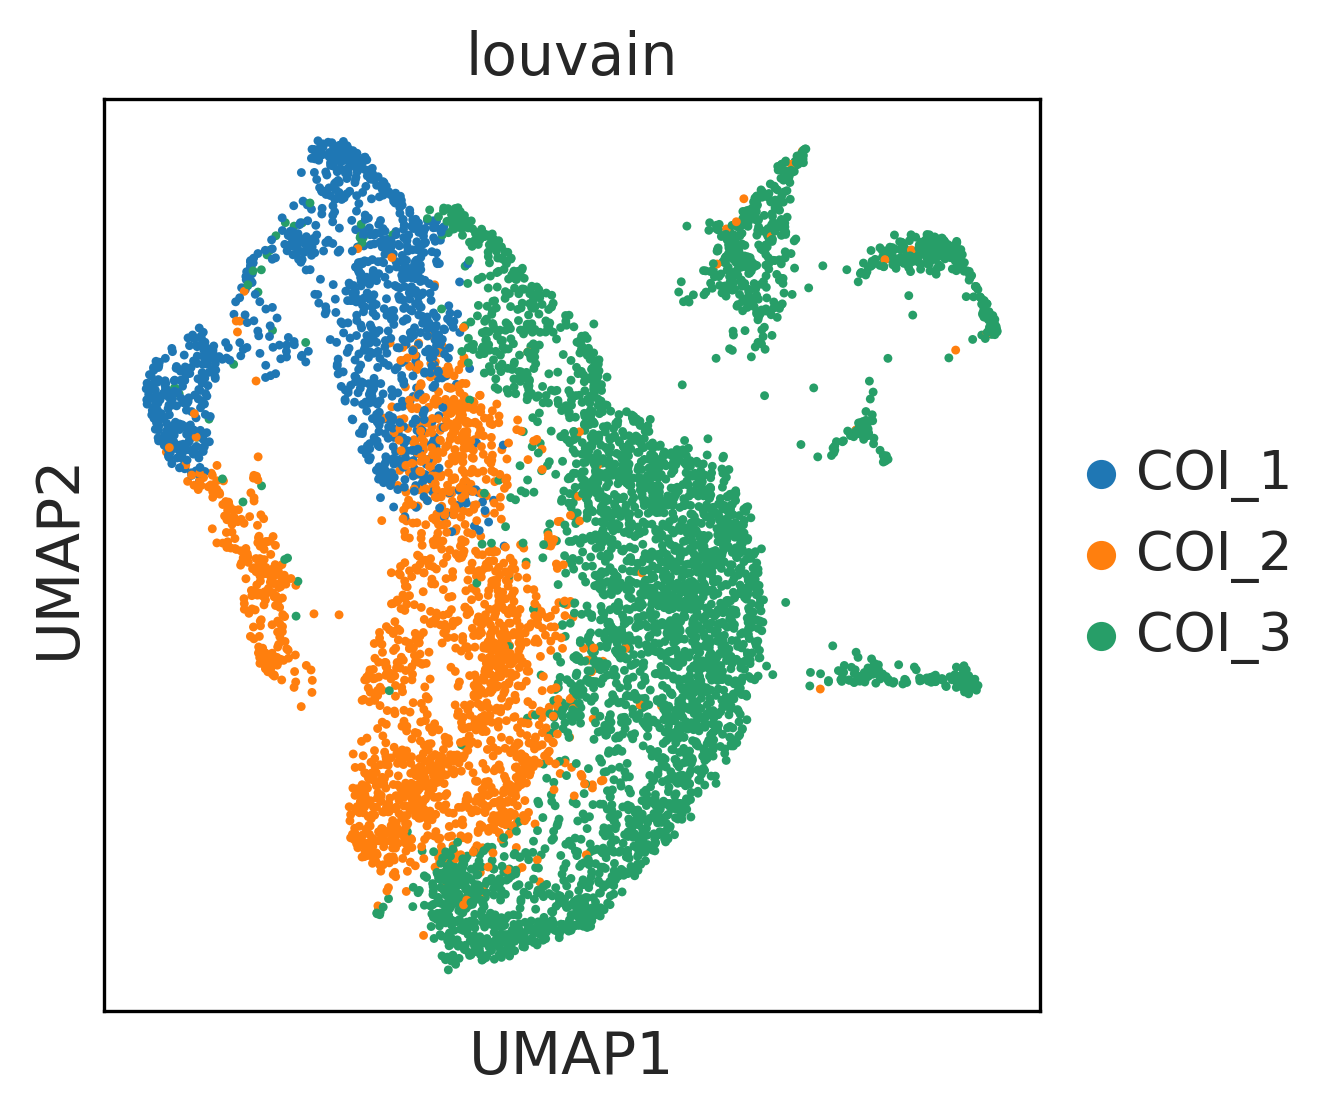

In [12]:
sc.pl.umap(adata, color = 'louvain')

#### Rename clusters

In [13]:
# new_cluster_names = ['']
# adata.rename_categories('louvain', new_cluster_names)
#adata.obs['cluster_annotation'] = adata.obs['louvain']

In [14]:
adata.obs['Timepoint'] = pd.Categorical(adata.obs['Timepoint'], categories = ["D0" ,"D1","D2","D3","D4","D5","D6","D7","D8","D9"], ordered = True)

In [15]:
adata.obs['Timepoint'].unique()

['D7', 'D6', 'D9', 'D8', 'D5', 'D4', 'D3', 'D2', 'D0', 'D1']
Categories (10, object): ['D0' < 'D1' < 'D2' < 'D3' ... 'D6' < 'D7' < 'D8' < 'D9']

In [16]:
adata.var['dispersions_norm'].head()

Aox1       1.255031
Rgs20      1.212775
Cacna1e    1.580562
Pax3       1.273136
Cd247      1.545826
Name: dispersions_norm, dtype: float64

In [17]:
adata.var.head()

vst.variance.standardized  vst.variable  highly_variable  \
Aox1                      1.255031          True             True   
Rgs20                     1.212775          True             True   
Cacna1e                   1.580562          True             True   
Pax3                      1.273136          True             True   
Cd247                     1.545826          True             True   

         dispersions_norm  
Aox1             1.255031  
Rgs20            1.212775  
Cacna1e          1.580562  
Pax3             1.273136  
Cd247            1.545826

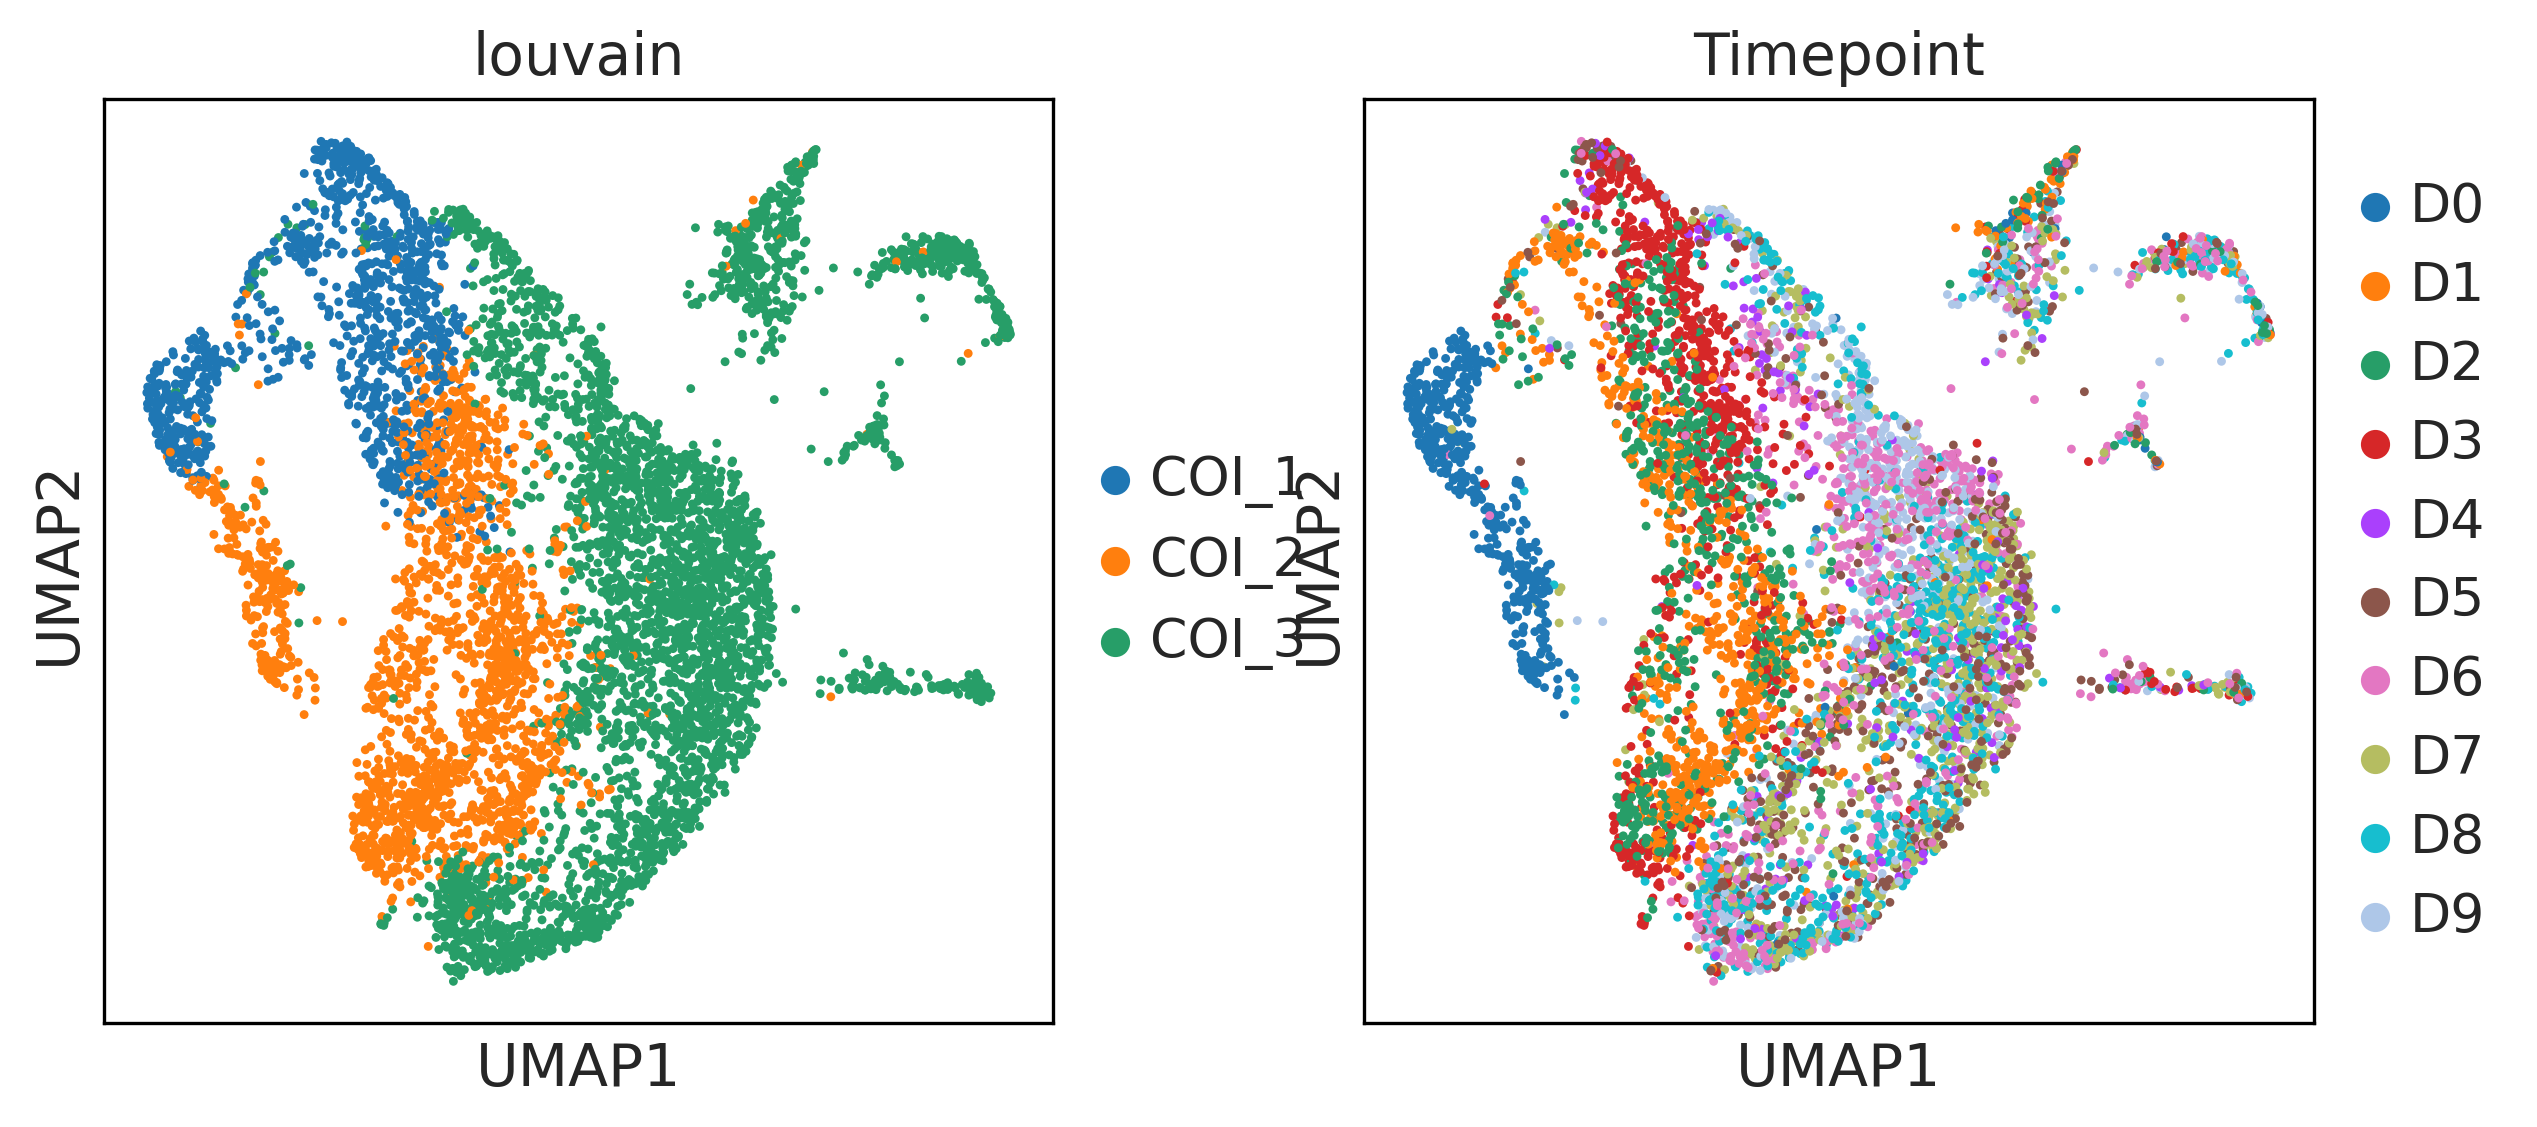

In [18]:
sc.pl.umap(adata, color = ['louvain','Timepoint'])

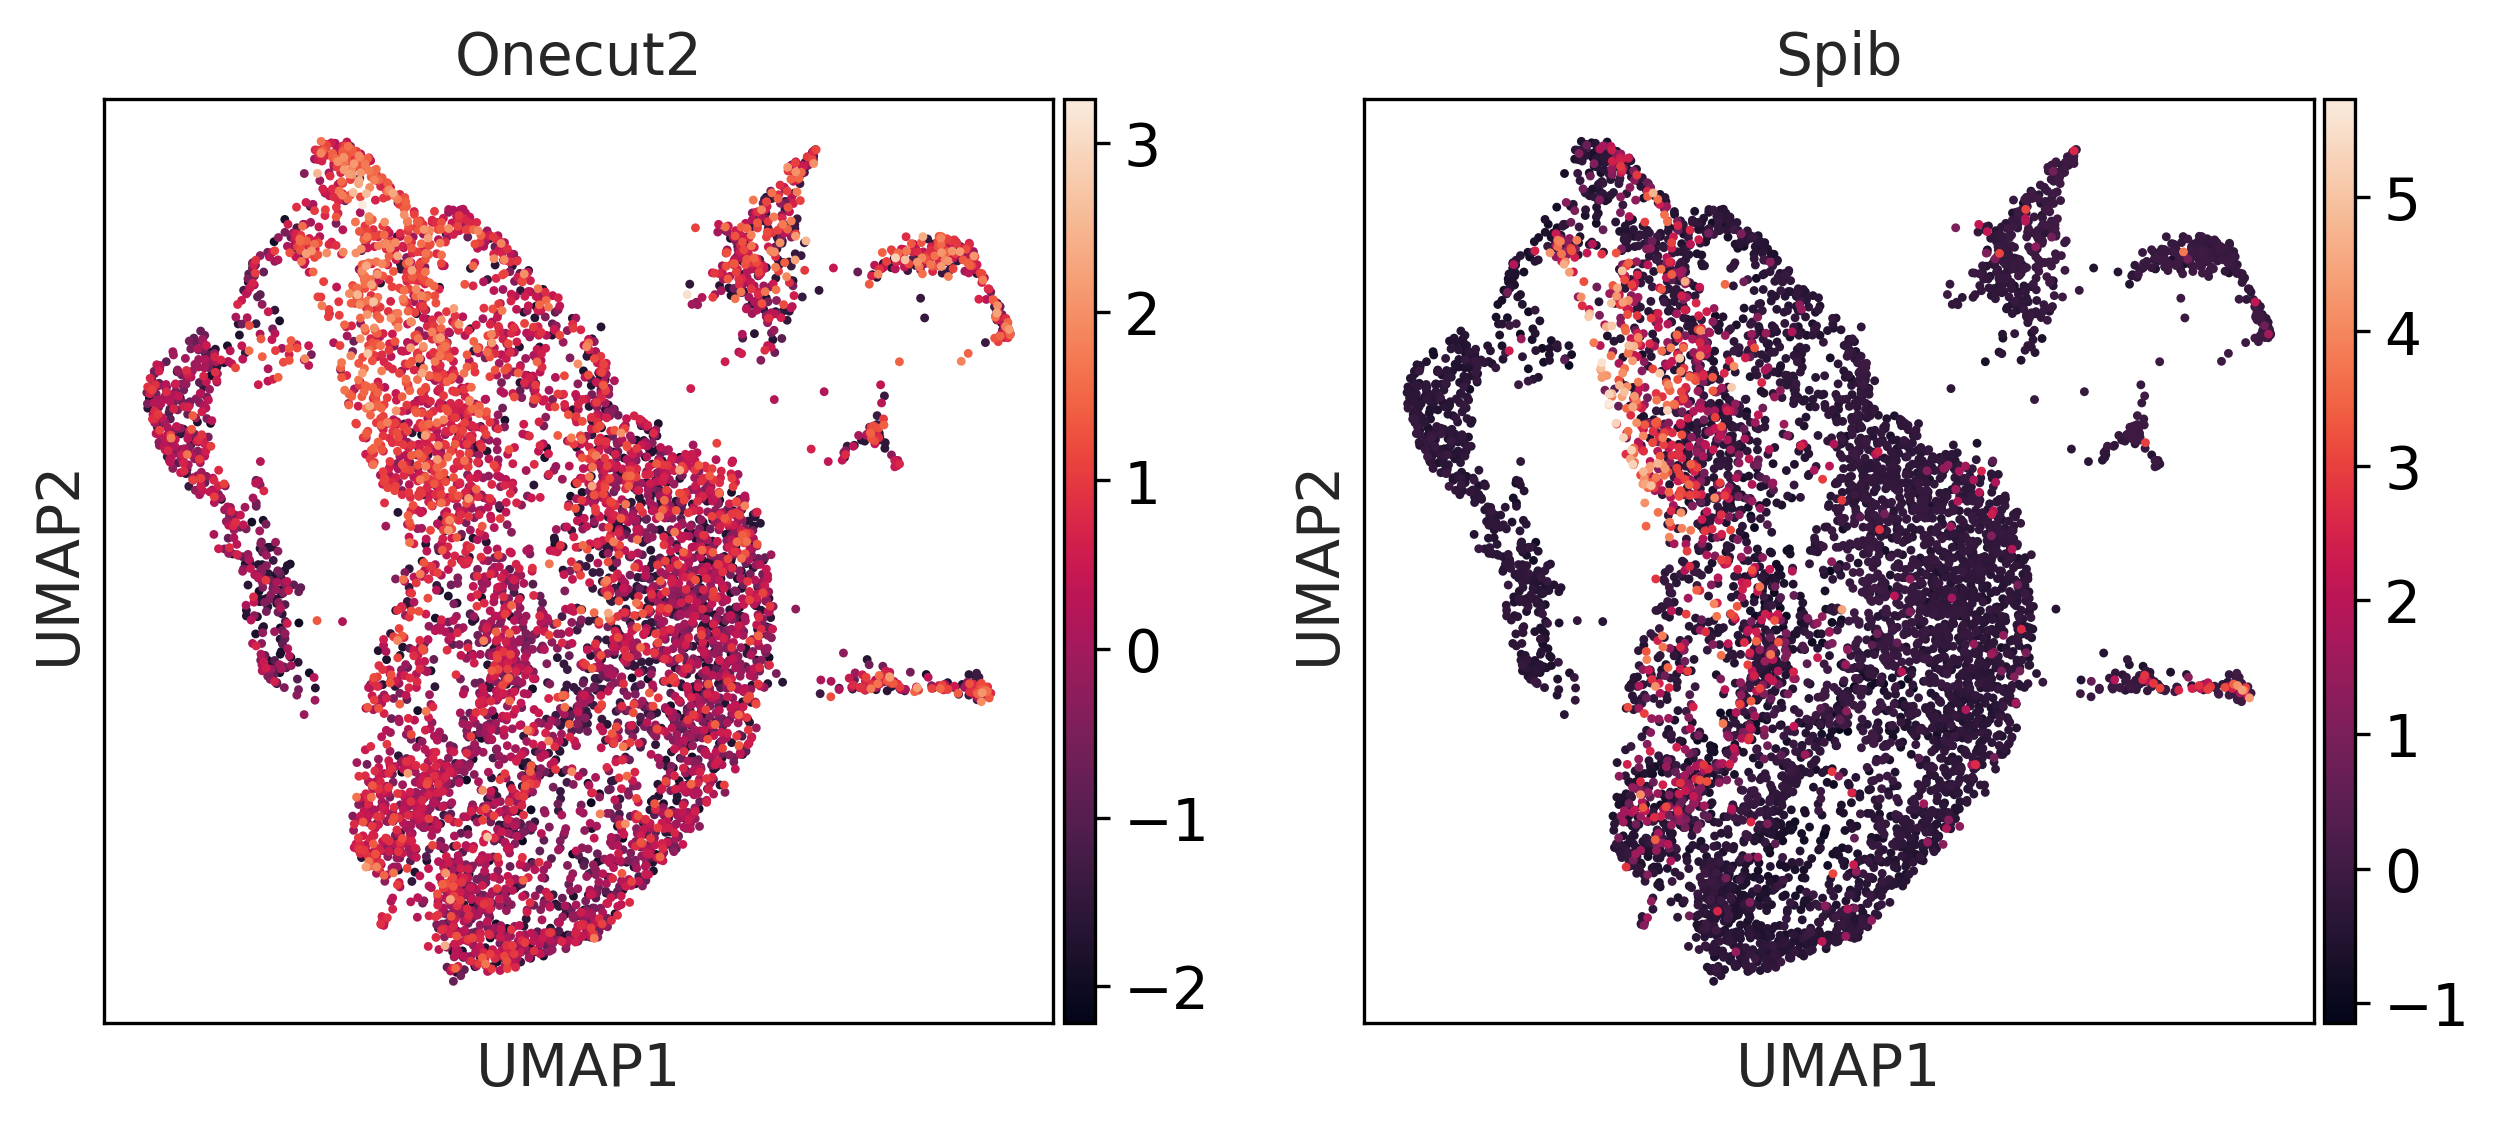

In [19]:
sc.pl.umap(adata, color = ['Onecut2','Spib'])

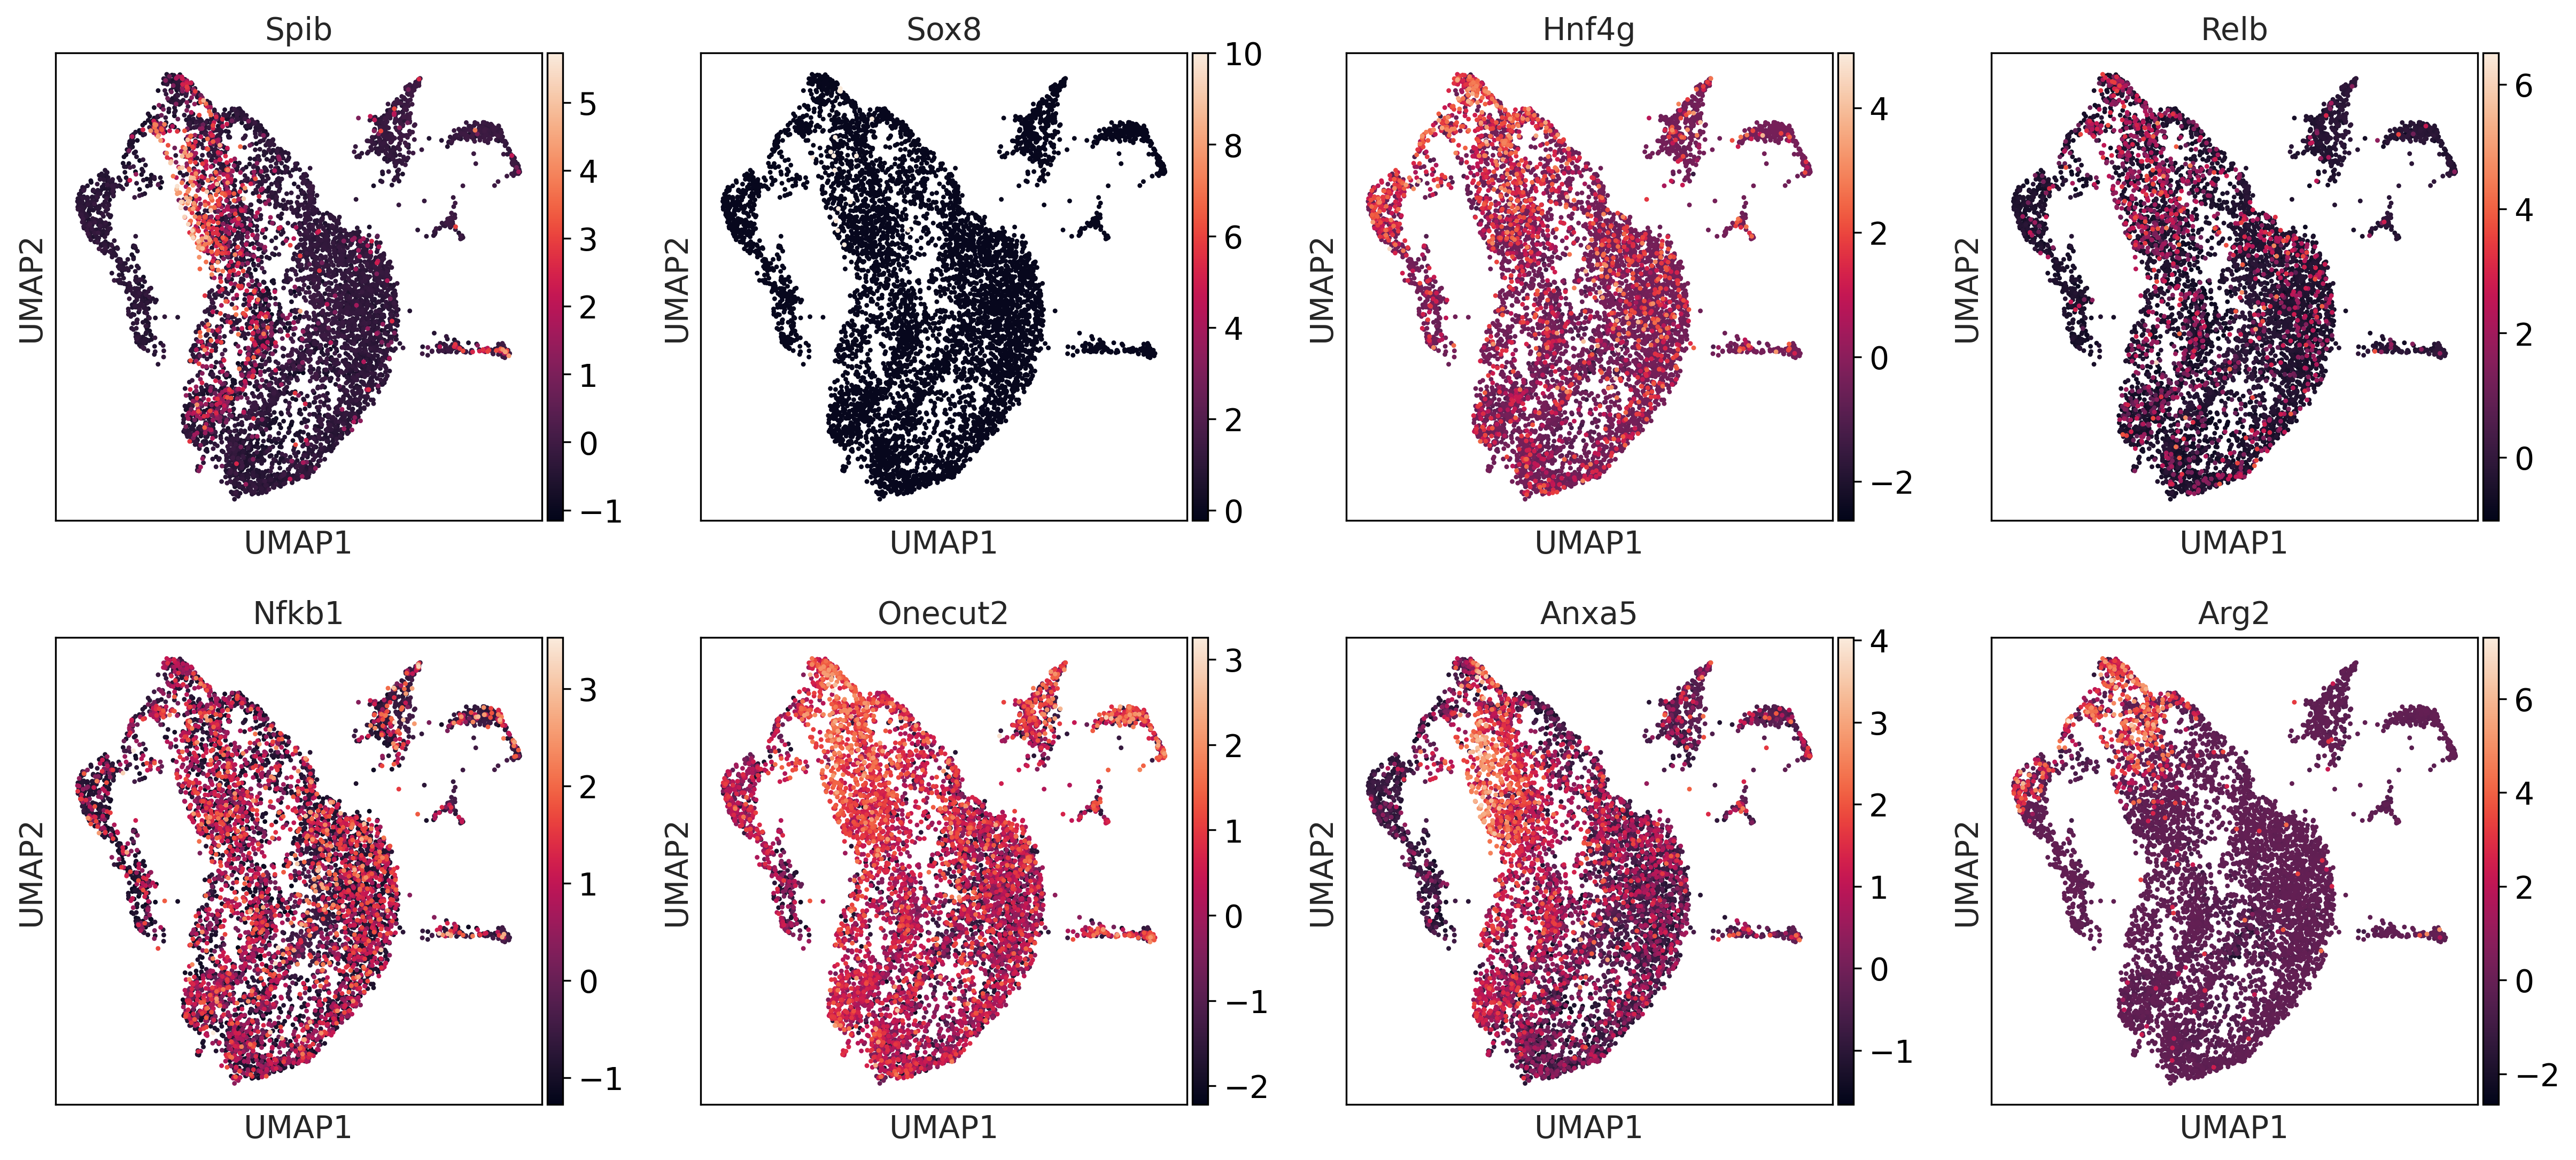

In [20]:
sc.pl.umap(adata, color = ['Spib', 'Sox8', 'Hnf4g', 'Relb', 'Nfkb1', 'Onecut2', 'Anxa5', 'Arg2'])

In [21]:
# ## Load genome
# import genomepy
# genomepy.install_genome("hg38")

In [22]:
infer_motifs(adata, dataset="ENCODE.H3K27ac.human", n_top_genes=2000, min_annotated = 1)

2021-12-20 17:15:26 - INFO - Loading reference data (gene).
2021-12-20 17:15:27 - INFO - Selecting reference cell types
2021-12-20 17:15:27 - INFO - Using 1405 hypervariable common genes
2021-12-20 17:15:28 - INFO - 50 out of 121 selected
2021-12-20 17:15:28 - INFO - Top 5:
2021-12-20 17:15:28 - INFO -  * thymus
2021-12-20 17:15:28 - INFO -  * myotube
2021-12-20 17:15:28 - INFO -  * HEK293
2021-12-20 17:15:28 - INFO -  * skeletal muscle myoblast
2021-12-20 17:15:28 - INFO -  * small intestine
2021-12-20 17:15:28 - INFO - Annotating cells.


  0%|          | 0/6636 [00:00<?, ?it/s]

2021-12-20 17:16:29 - INFO - Linking variable genes to differential enhancers.
2021-12-20 17:16:38 - INFO - Loading reference data (enhancer).
2021-12-20 17:17:08 - INFO - inferring motif activity
2021-12-20 17:17:08 - INFO - Activity based on genome hg38
2021-12-20 17:17:12,962 - INFO - motif scanning (scores)
2021-12-20 17:17:12,965 - INFO - reading table
2021-12-20 17:17:21,234 - INFO - creating score table (z-score, GC%)
2021-12-20 17:18:51,515 - INFO - done
2021-12-20 17:18:53,806 - INFO - creating dataframe
2021-12-20 17:18:57,285 - INFO - Fitting BayesianRidge


  0%|          | 0/50 [00:00<?, ?it/s]

2021-12-20 17:21:58,067 - INFO - Done
2021-12-20 17:21:58 - INFO - calculating cell-specific motif activity
2021-12-20 17:21:58 - INFO - correlating motif activity with factors
2021-12-20 17:21:58 - INFO - including indirect and/or predicted factors
2021-12-20 17:22:00 - INFO - creating sketch of 2500 cells
2021-12-20 17:22:05 - INFO - calculating correlation of motif activity with 609 factors
2021-12-20 17:22:09 - INFO - calculating 100000 permutations


  0%|          | 0/60 [00:00<?, ?it/s]

2021-12-20 17:32:25 - INFO - calculating permutation-based p-values (all)
2021-12-20 17:36:17 - INFO - calculating permutation-based p-values (factor-specific)


  0%|          | 0/3299 [00:00<?, ?it/s]

2021-12-20 17:36:22 - INFO - Inferring factor activity.


  0%|          | 0/609 [00:00<?, ?it/s]

2021-12-20 17:37:56 - INFO - Done with motif inference.


... storing 'cluster_annotation' as categorical
... storing 'cell_annotation' as categorical


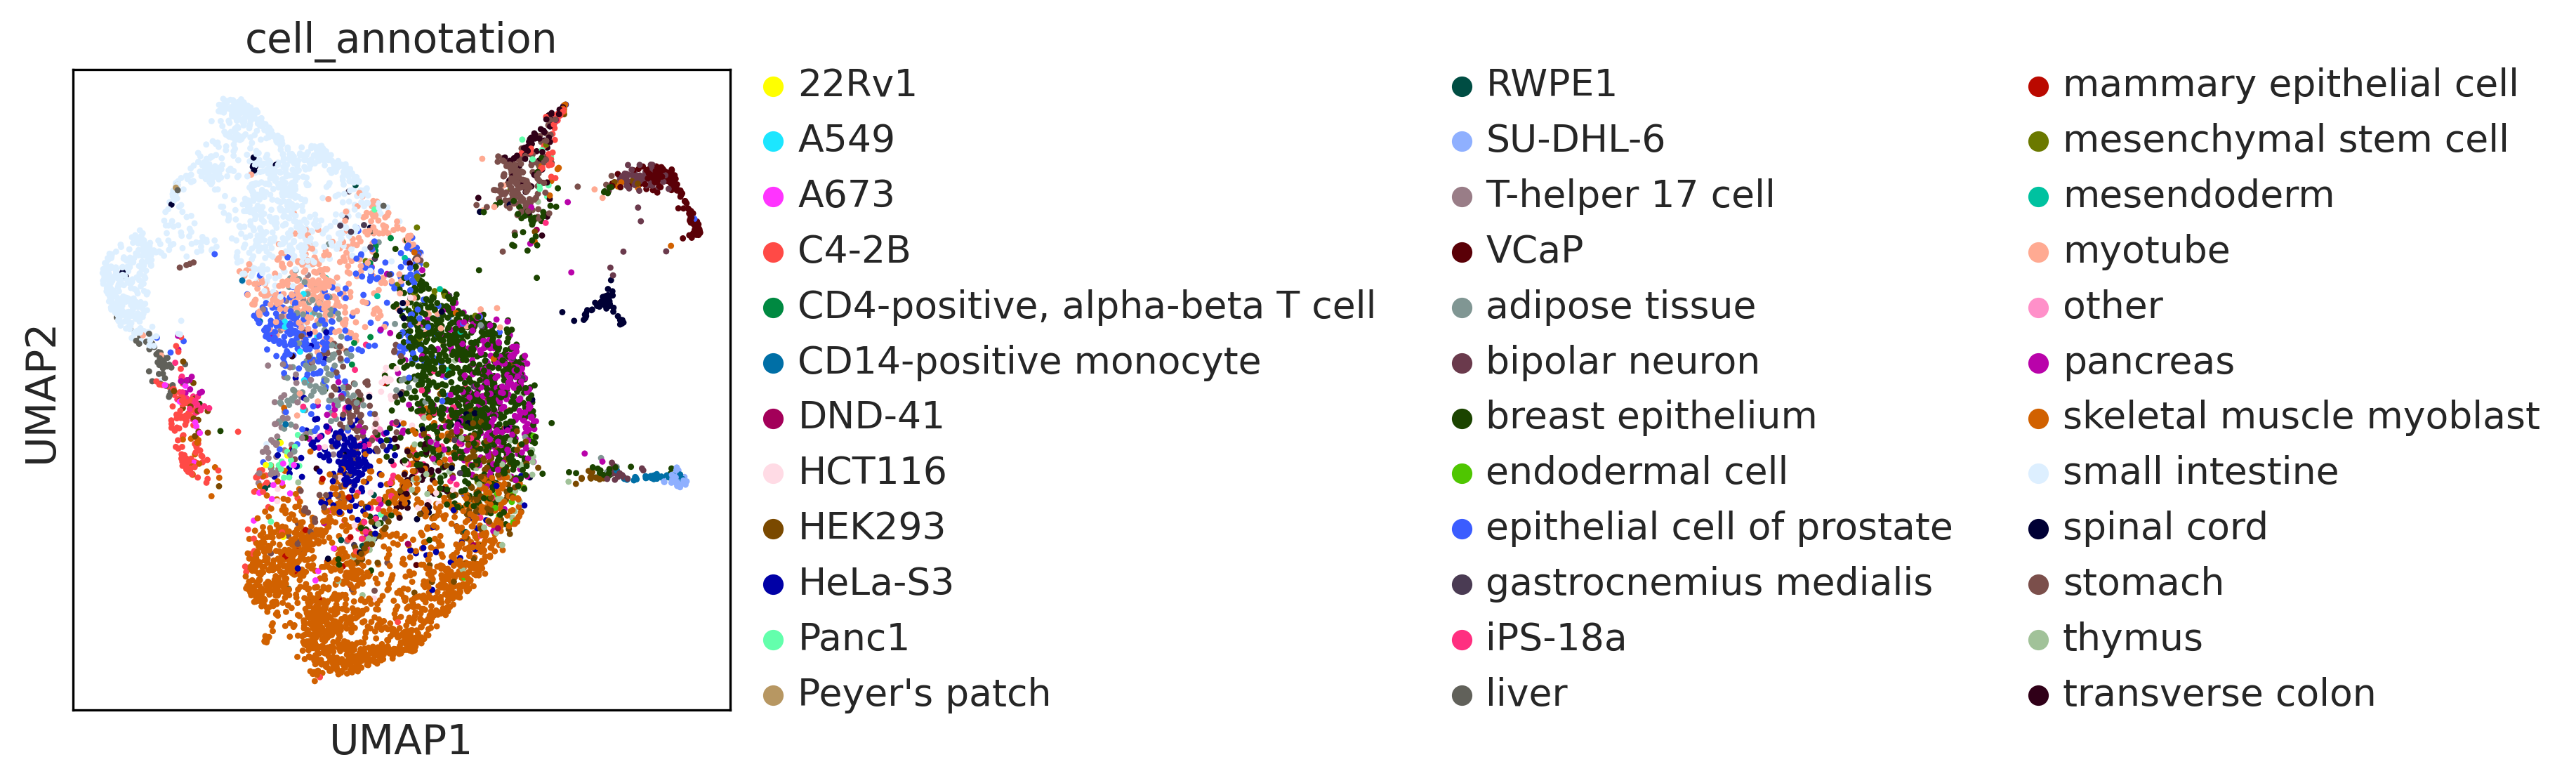

In [23]:
sc.pl.umap(adata, color="cell_annotation")

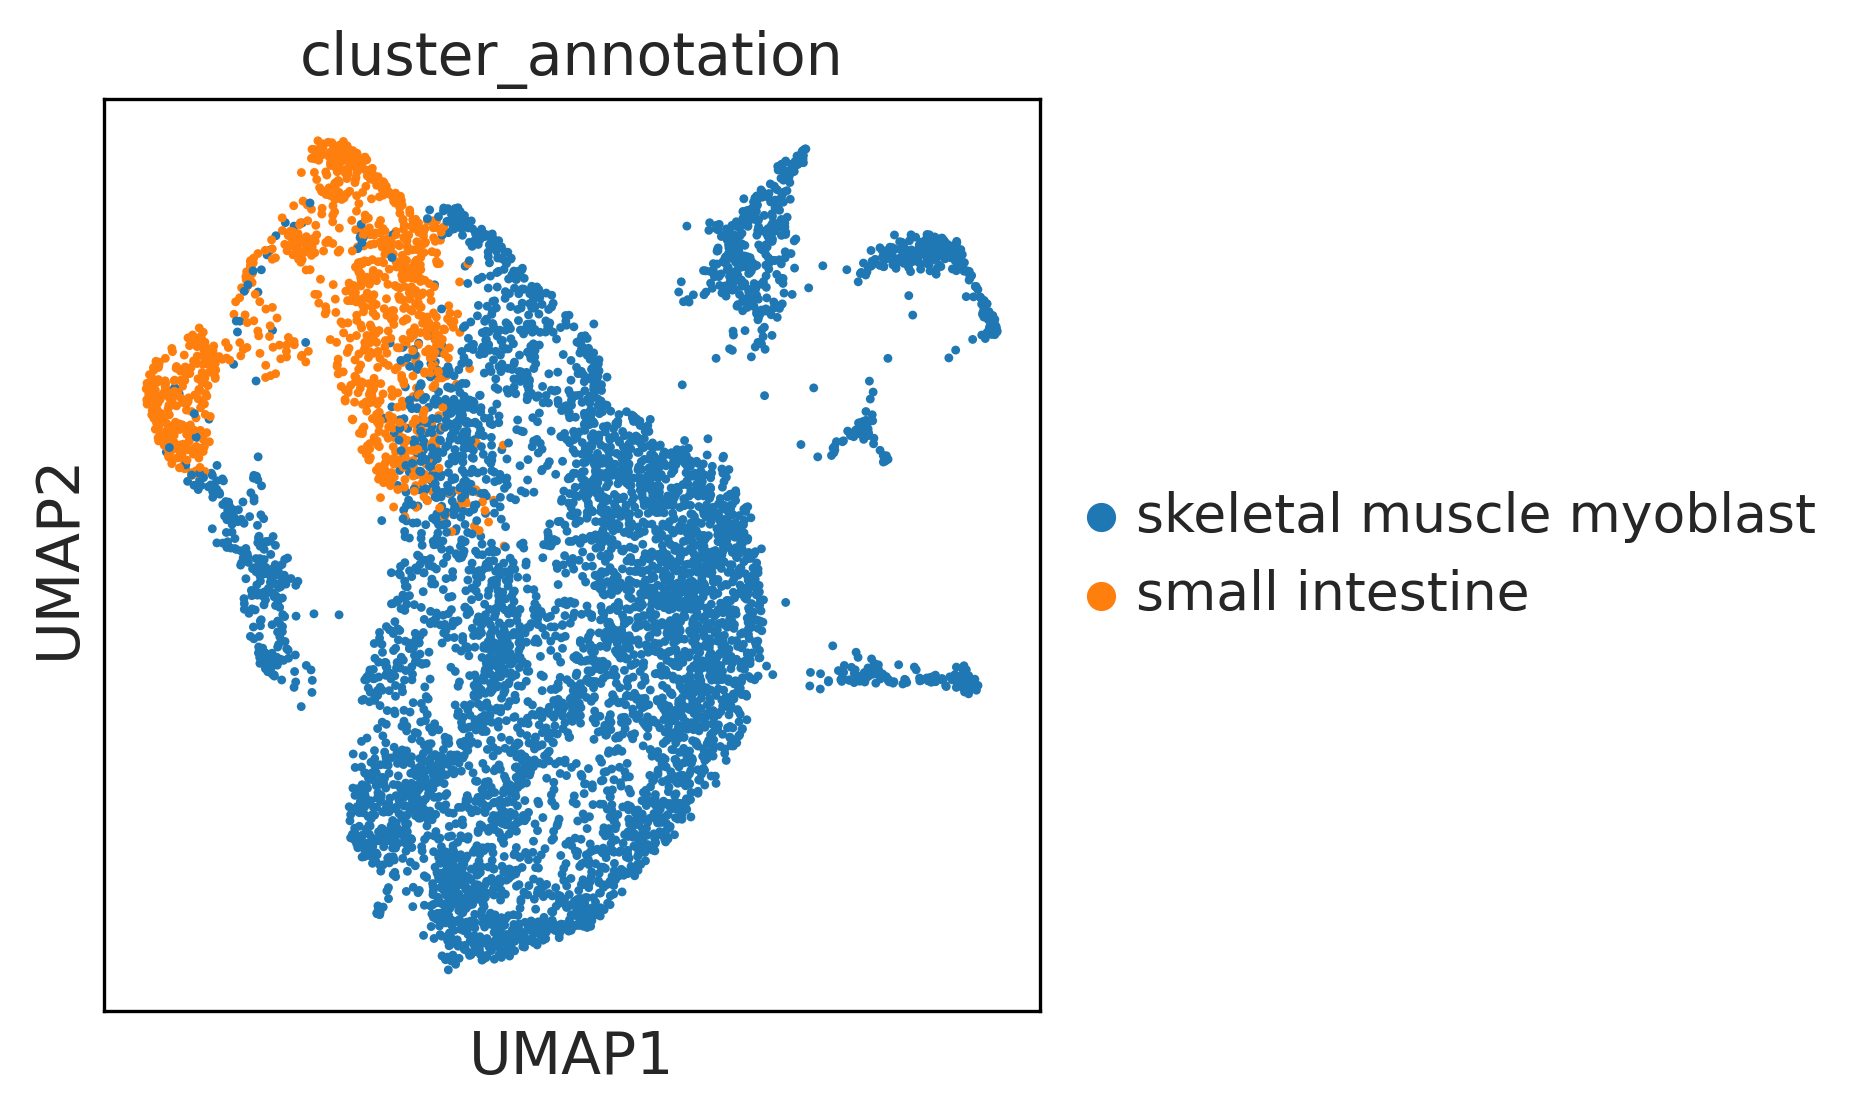

In [24]:
sc.pl.umap(adata, color="cluster_annotation")

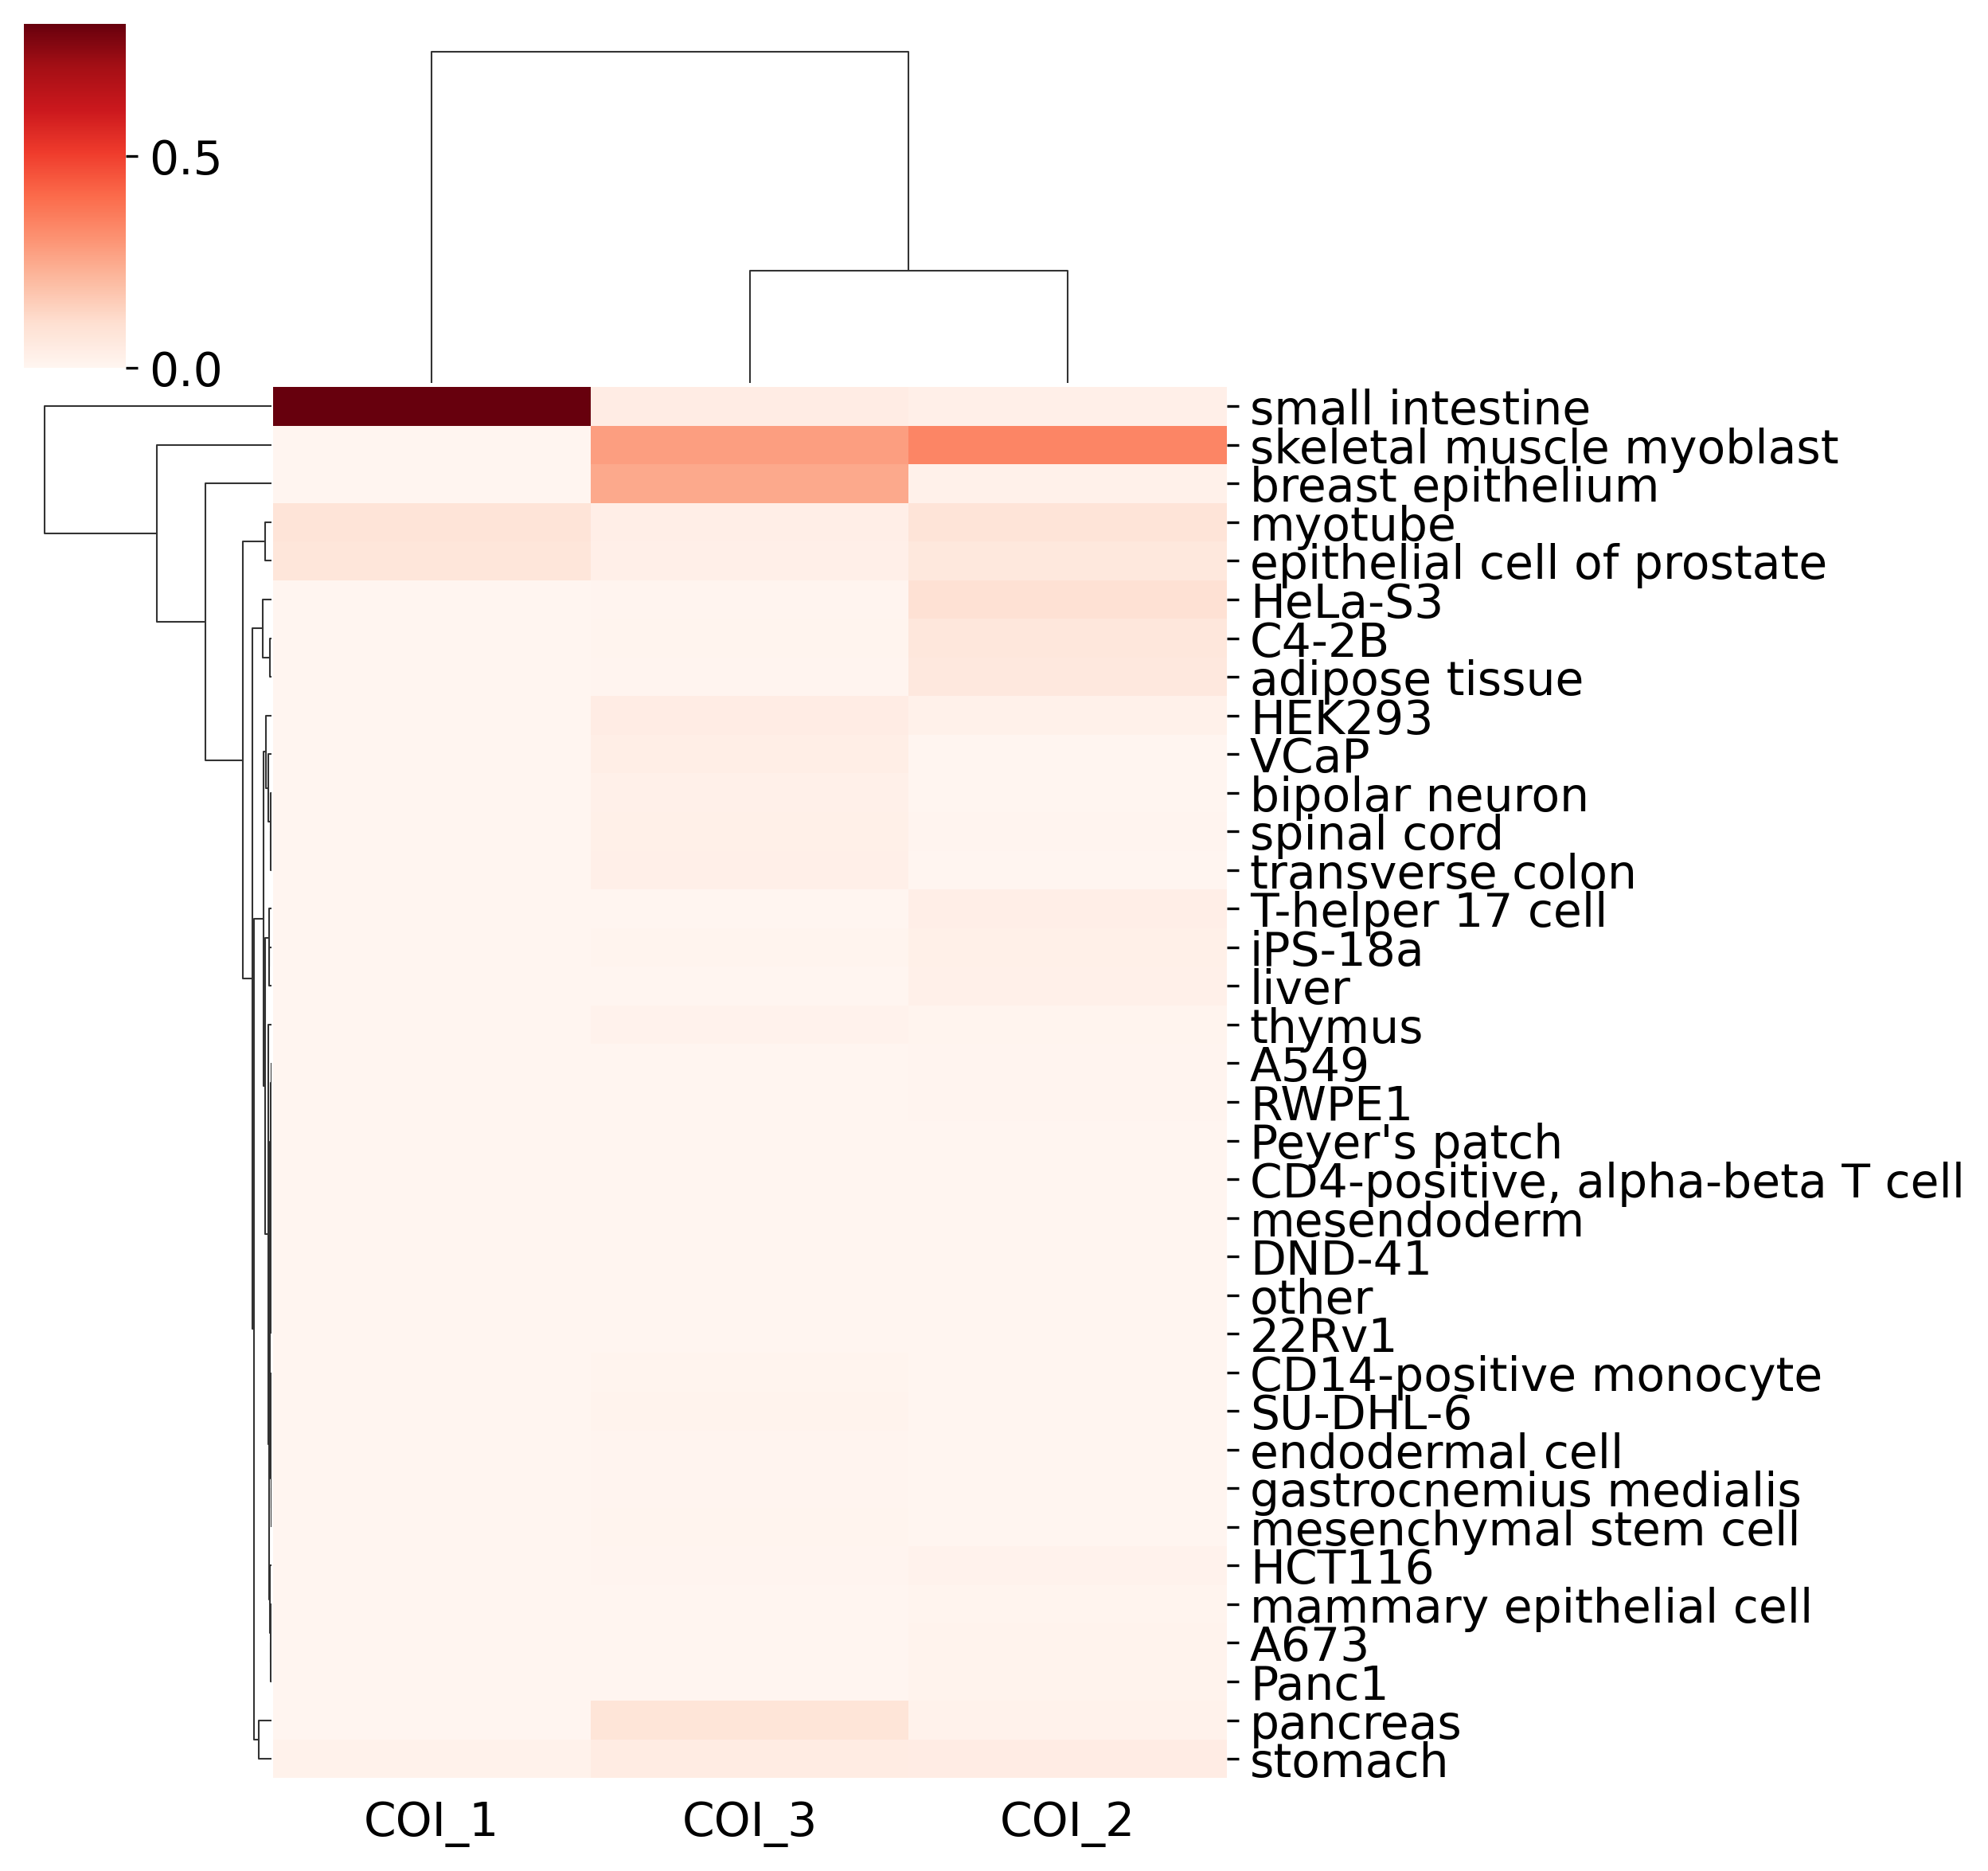

In [25]:
labels = list(set(np.hstack((adata.obs["louvain"].astype(str).unique(), adata.obs["cell_annotation"].astype(str).unique()))))

cnf_matrix = pd.DataFrame(confusion_matrix(adata.obs["louvain"], adata.obs["cell_annotation"], labels=labels), index=labels, columns=labels)
cnf_matrix = cnf_matrix.loc[adata.obs["louvain"].astype(str).unique(), adata.obs["cell_annotation"].astype(str).unique()]
cnf_matrix = cnf_matrix.div(cnf_matrix.sum(1), axis=0)
cm = sns.clustermap(cnf_matrix.T, cmap="Reds", figsize=(8.5,8), yticklabels=True)

In [26]:
adata.uns["scepia"].keys()

dict_keys(['version', 'cell_types', 'pfm', 'motif_activity', 'correlation'])

In [27]:
adata.uns["scepia"]["correlation"].sort_values("p_adj").head(10)

motif  correlation  abs_correlation  \
factor                                                                   
CREB3L3                 GM.5.0.bZIP.0041    -0.763459         0.763459   
HNF4G       GM.5.0.Nuclear_receptor.0068     0.436634         0.436634   
HNF4G       GM.5.0.Nuclear_receptor.0096     0.434906         0.434906   
SP8                  GM.5.0.C2H2_ZF.0174    -0.109397         0.109397   
HNF4G       GM.5.0.Nuclear_receptor.0056     0.435404         0.435404   
HNF4G                  GM.5.0.Mixed.0003     0.435345         0.435345   
ARX              GM.5.0.Homeodomain.0087     0.278578         0.278578   
ZEB1     GM.5.0.C2H2_ZF_Homeodomain.0002    -0.197299         0.197299   
HNF4G       GM.5.0.Nuclear_receptor.0028     0.432075         0.432075   
SMARCC2                 GM.5.0.bZIP.0019    -0.153926         0.153926   

             pval  permutation_pval  combined     p_adj  -log10(p-value)  \
factor                                                                     
CREB3L3  0.000033          0.020049  0.000010  0.010366         1.984368   
HNF4G    0.000836          0.000779  0.000010  0.010366         1.984368   
HNF4G    0.000853          0.001519  0.000019  0.010366         1.984368   
SP8      0.068037          0.000010  0.000010  0.010366         1.984368   
HNF4G    0.000848          0.001302  0.000016  0.010366         1.984368   
HNF4G    0.000849          0.001331  0.000017  0.010366         1.984368   
ARX      0.006328          0.000256  0.000023  0.010960         1.960206   
ZEB1     0.019524          0.000128  0.000035  0.014345         1.843284   
HNF4G    0.000882          0.003393  0.000041  0.015040         1.822738   
SMARCC2  0.035604          0.000118  0.000056  0.018595         1.730612   

         motif_stddev  
factor                 
CREB3L3      0.002632  
HNF4G        0.007962  
HNF4G        0.033741  
SP8          0.009158  
HNF4G        0.039067  
HNF4G        0.007087  
ARX          0.001909  
ZEB1         0.025018  
HNF4G        0.029080  
SMARCC2      0.006495

In [28]:
corr_table = adata.uns["scepia"]["correlation"].sort_values("p_adj")
corr_table.to_csv(work_dir + "SCEPIA_corr_table.csv")

In [29]:
## Keep tf-motif combination with highest correlation
corr_table[~corr_table.index.duplicated(keep='first')].head(60)

motif  correlation  abs_correlation  \
factor                                                                    
CREB3L3                  GM.5.0.bZIP.0041    -0.763459         0.763459   
HNF4G        GM.5.0.Nuclear_receptor.0068     0.436634         0.436634   
SP8                   GM.5.0.C2H2_ZF.0174    -0.109397         0.109397   
ARX               GM.5.0.Homeodomain.0087     0.278578         0.278578   
ZEB1      GM.5.0.C2H2_ZF_Homeodomain.0002    -0.197299         0.197299   
SMARCC2                  GM.5.0.bZIP.0019    -0.153926         0.153926   
SOX4                      GM.5.0.Sox.0003    -0.507860         0.507860   
PAX4              GM.5.0.Homeodomain.0014     0.436302         0.436302   
KLF6                  GM.5.0.C2H2_ZF.0006     0.239912         0.239912   
KLF5                  GM.5.0.C2H2_ZF.0006     0.376284         0.376284   
BDP1                    GM.5.0.Mixed.0104    -0.152587         0.152587   
KLF3                  GM.5.0.C2H2_ZF.0006     0.126320         0.126320   
BHLHE40                  GM.5.0.bHLH.0026    -0.245836         0.245836   
NR1H4        GM.5.0.Nuclear_receptor.0077    -0.252802         0.252802   
NEUROD2                  GM.5.0.bHLH.0036     0.346020         0.346020   
NEUROG3                  GM.5.0.bHLH.0036     0.332246         0.332246   
CEBPB                    GM.5.0.bZIP.0052     0.172283         0.172283   
PRRX1             GM.5.0.Homeodomain.0146     0.227338         0.227338   
ELF1                      GM.5.0.Ets.0021     0.168893         0.168893   
TCF7L2                  GM.5.0.Mixed.0092     0.306265         0.306265   
FOXP4                GM.5.0.Forkhead.0019     0.077252         0.077252   
IRF7                      GM.5.0.IRF.0012    -0.276916         0.276916   
EGR1                    GM.5.0.Mixed.0026    -0.239326         0.239326   
JUNB                     GM.5.0.bZIP.0036     0.196369         0.196369   
MAF                      GM.5.0.bZIP.0091    -0.278159         0.278159   
SOX9                      GM.5.0.Sox.0018     0.357329         0.357329   
TFDP1                     GM.5.0.E2F.0002     0.266781         0.266781   
HOXD13            GM.5.0.Homeodomain.0030     0.050085         0.050085   
AHRR                     GM.5.0.bHLH.0051    -0.088507         0.088507   
GABPA                     GM.5.0.Ets.0003     0.082678         0.082678   
ONECUT2       GM.5.0.CUT_Homeodomain.0005     0.330889         0.330889   
FOXA1                GM.5.0.Forkhead.0058    -0.274296         0.274296   
NR3C2        GM.5.0.Nuclear_receptor.0086     0.138180         0.138180   
FUBP1                 GM.5.0.Unknown.0146     0.295740         0.295740   
BCL11A                   GM.5.0.bZIP.0017    -0.114246         0.114246   
ELF2                      GM.5.0.Ets.0026    -0.089810         0.089810   
STAT1                    GM.5.0.STAT.0024     0.148894         0.148894   
ESRRB        GM.5.0.Nuclear_receptor.0057    -0.084589         0.084589   
PPARA        GM.5.0.Nuclear_receptor.0041     0.233940         0.233940   
ESRRA        GM.5.0.Nuclear_receptor.0082     0.254567         0.254567   
RAD21                   GM.5.0.Mixed.0007    -0.307230         0.307230   
RUNX1                    GM.5.0.Runt.0003     0.166106         0.166106   
PRRXL1            GM.5.0.Homeodomain.0157     0.104230         0.104230   
RXRA         GM.5.0.Nuclear_receptor.0020     0.169425         0.169425   
RUNX2                    GM.5.0.Runt.0001     0.080385         0.080385   
RFX6                      GM.5.0.RFX.0003     0.316166         0.316166   
FEV                       GM.5.0.Ets.0024    -0.245039         0.245039   
POU6F2        GM.5.0.Homeodomain_POU.0013     0.094699         0.094699   
PPARGC1A     GM.5.0.Nuclear_receptor.0109    -0.045909         0.045909   
IRF1                      GM.5.0.IRF.0006     0.171277         0.171277   
NFIX                     GM.5.0.SMAD.0006     0.152883         0.152883   
ETS1                     GM.5.0.bZIP.0017    -0.307931       

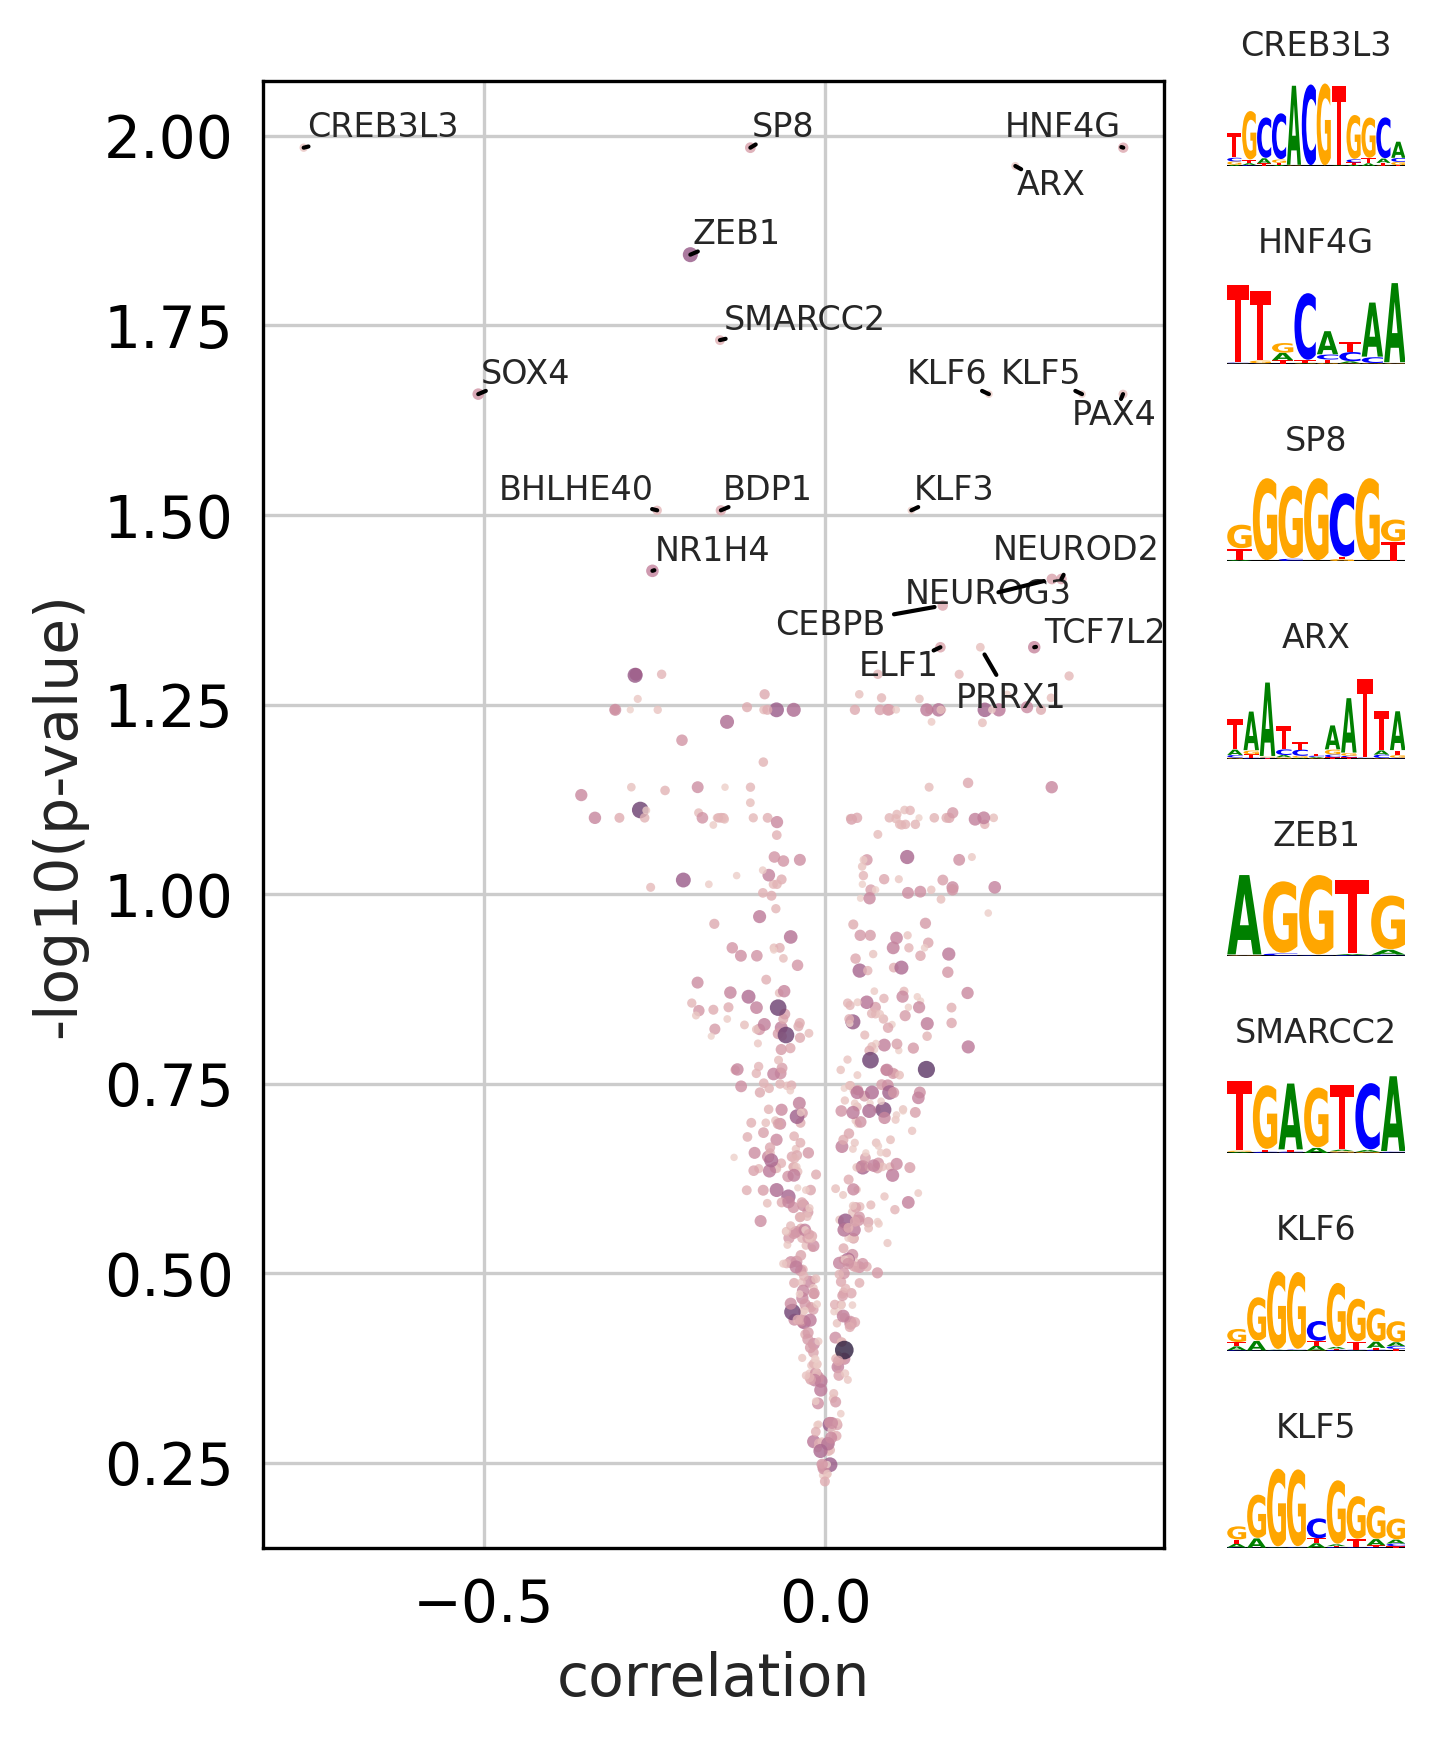

In [31]:
ax = plot(adata, n_anno=50, max_pval = 0.05)